## This whole notebook wa an exploration in class imbalance to see if using 1:1 would help elucidate the cut between the sweet 16 and the losers

## I think it actually did prove useful, although I am unsure of whether or not  i am going to use the PCA for 13-19,21, then use an SVC trained with 13-19, class imbalance, 13-19, SMOTE, all class imbalance, all SMOTE

## Through the testing, I beleive rbf SVC trained with 13-19 data with SMOTE class balance will prove the best results. i think using all the data will be overfitting, but then again, i'm doing a lot of ad hoc here so it may nto make a difference.

# The end goal fo ths is to try and identify a set of predicted sweet 16 teams. Since i am not constraining to bracket order, i hopefully will get a list of teams with high potentials for long runs.

# In actuality, my binary clustering is whether or not a team has longevity in the tournament

# 1 observation - 13-19 is biased towards big tem

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split,cross_validate, cross_val_score, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from imblearn.over_sampling import SMOTE



In [189]:
train_df = pd.read_csv('./archive/cbb.csv')
train_df = train_df[train_df['SEED'] < 17.0]
train_df.reset_index()
test_df = pd.read_csv('./archive/cbb21.csv')
test_df[test_df['SEED'] < 17.0]
test_df.reset_index()

y_post = np.array(train_df['POSTSEASON'])
y_post = y_post.reshape(len(y_post),1)
cats = np.array(['Champions', '2ND', 'F4', 'E8', 'S16', 'R32', 'R64', 'R68'][::-1])
cats = list(cats.reshape(1,-1))


onehot = OneHotEncoder(categories=cats, sparse=False)

onehot_encode = onehot.fit_transform(y_post)
y_group=np.array([None]*onehot_encode.shape[0])
for i,row in enumerate(onehot_encode):
    idx = list(np.where(row == 1)[0])
   
    if idx[0] < 2.5:
        y_group[i] = 0
    elif idx[0] > 2.5:
        y_group[i] = 1
        
smote = SMOTE()
x_cats = ['TEAM','ADJOE','ADJDE','EFG_O','EFG_D','TOR', 'TORD', 'ORB','FTRD', '2P_D', '3P_O', '3P_D','ADJ_T']
X = train_df[x_cats]
X_test = test_df[x_cats]
# y-test
sweet_16 = ['Gonzaga', 'Creighton', 'USC', 'Oregon', 'Michigan', 'Florida St.','UCLA','Alabama','Baylor','Villanova','Arkansas','Oral Roberts', 'Loyola Chicago', 'Oregon St.', 'Syracuse','Houston']
index_list = []
for t in sweet_16:
    index_list.append(X_test.loc[X_test['TEAM'] == t].index[0])
sweet_g21 = np.zeros(X_test.shape[0])
sweet_g21[index_list] = 1
y_group = y_group.astype(int)
print(type(y_group),type(sweet_g21))
y1 = np.hstack([y_group,sweet_g21])
#print(y1,sweet_g21)
X1 = pd.concat([X,X_test],axis=0)
#X_test=X_test.set_index('TEAM')
X1=X1.set_index('TEAM')
X, y_even = smote.fit_resample(X1,y1)


X.shape
from sklearn.model_selection import KFold
kfold = KFold(n_splits=6)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


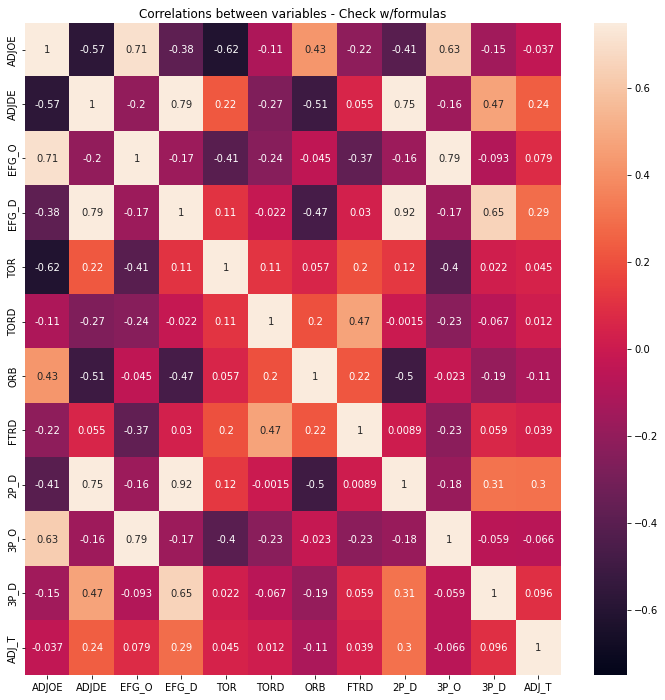

In [154]:
plt.figure(figsize=(12,12))
sns.heatmap(X.corr(),vmin=-.75,vmax=.75,annot=True)
plt.title('Correlations between variables - Check w/formulas')
plt.show()

In [184]:
pca = PCA(n_components=10)
pca.fit(X)
Xpca = pca.fit_transform(X)
x_train, x_test, y_train, y_test = train_test_split(X,y_even,test_size=0.1,shuffle=True)

pca.explained_variance_ratio_

array([0.49350045, 0.2002462 , 0.12069292, 0.05616084, 0.04027279,
       0.03161531, 0.01981944, 0.01693707, 0.00989604, 0.00732374])

#checking first pca components for splittign ability of sweet 16 and else
fig=plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')
scat = ax.scatter(Xpca[:,0],Xpca[:,1],Xpca[:,2],c=y_even,cmap='winter')


ax.set_xlabel('pca1')
ax.set_ylabel('pca2')
ax.set_zlabel('pca3')
ax.legend(handles=scat.legend_elements()[0],labels = ['Not S16', 'S16+'])

ax.view_init(15,45)
plt.show()

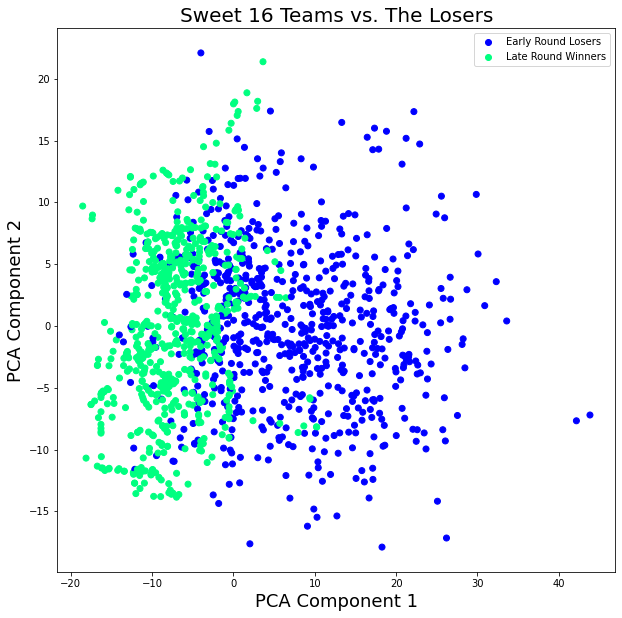

In [201]:
fig=plt.figure(figsize=(10,10))
scat = plt.scatter(Xpca[:,0],Xpca[:,1],c=y_even,cmap='winter')
plt.xlabel('PCA Component 1',fontsize=18)
plt.ylabel('PCA Component 2', fontsize=18)
plt.title('Sweet 16 Teams vs. The Losers', fontsize=20)
plt.legend(handles=scat.legend_elements()[0],labels = ['Early Round Losers', 'Late Round Winners'])
plt.show()

In [176]:
#X_testpca = pca.transform(X_test)


In [177]:
def precision_recall(y_test, predicted_y):
    tn, fp, fn, tp = confusion_matrix(y_test, predicted_y).ravel()
    precision_score = tp / (tp + fp)
    recall_score = tp / (tp + fn)
    return precision_score, recall_score

In [178]:
svm = sklearn.svm.SVC(kernel='rbf')
y_even = y_even.astype(int)
scores = cross_validate(svm,Xpca[:,0:3],y_even,scoring=('precision', 'recall'),cv=kfold)
scores

{'fit_time': array([0.02366996, 0.03064084, 0.03231001, 0.03438497, 0.02745199,
        0.02472901]),
 'score_time': array([0.01090503, 0.0281353 , 0.01415777, 0.01452804, 0.01690912,
        0.01321697]),
 'test_precision': array([0.30635838, 0.45555556, 0.51219512, 0.97916667, 1.        ,
        1.        ]),
 'test_recall': array([0.94642857, 0.93181818, 0.75      , 0.8952381 , 0.81818182,
        0.79220779])}

# This shows great promsie as a potential classifier

In [180]:
svm_split = sklearn.svm.SVC(kernel='rbf')
svm_split.fit(x_train,y_train)
preds = svm_split.predict(x_test)
prec, rec = precision_recall(y_test,preds)

In [199]:
(preds == y_test).sum() /len(y_test)

0.5107913669064749

In [192]:
#x_test[np.where(preds==1)]

In [95]:
X_test.iloc[np.where(sweet_g21==1)]

,ADJOE,ADJDE,EFG_O,EFG_D,TOR,TORD,ORB,FTRD,2P_D,3P_O,3P_D,ADJ_T
TEAM,,,,,,,,,,,,
Michigan,118.1,91.1,54.9,44.9,16.3,15.1,29.4,24.5,42.3,38.7,33.5,66.9
Baylor,123.2,94.5,57.5,49.1,17.6,24.6,37.5,31.7,48.1,41.8,34.0,68.8
Gonzaga,125.4,89.8,61.0,47.5,16.1,20.3,30.4,25.9,46.8,36.5,32.5,74.6
Houston,120.6,90.9,51.3,42.9,16.3,21.6,39.4,42.4,43.0,35.5,28.5,65.0
Alabama,111.0,88.1,51.3,45.3,18.6,21.1,31.5,31.9,46.4,35.1,28.8,73.9
Arkansas,110.4,91.2,51.5,47.6,17.4,20.3,31.7,29.3,46.9,33.9,32.6,73.1
Florida St.,117.8,94.0,54.4,46.5,20.1,19.6,35.4,36.3,44.2,39.0,33.3,70.4
Villanova,117.9,96.7,52.8,51.8,13.5,19.0,27.9,25.8,51.0,35.2,35.4,65.1
Creighton,114.4,94.3,55.7,46.9,15.8,17.8,24.8,25.7,46.1,36.7,32.1,69.1


In [205]:
print(X1.iloc[41])

ADJOE    115.7
ADJDE     85.7
EFG_O     55.2
EFG_D     43.3
TOR       17.8
TORD      22.5
ORB       34.2
FTRD      29.9
2P_D      41.8
3P_O      37.8
3P_D      31.0
ADJ_T     62.8
Name: Florida, dtype: float64


In [195]:
y_test

array([1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1])

In [186]:
y_test


array([1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1])